In [1]:
from scqubits.settings import matplotlib_settings
import matplotlib as mpl
from matplotlib.axes import Axes
from scqubits.utils.plot_utils import _extract_kwargs_options
from numpy import ndarray
from scqubits.utils.misc import InfoBar, process_which
import scqubits.core.constants as constants
from scqubits.utils.spectrum_utils import (
    get_matrixelement_table,
    order_eigensystem,
    recast_esys_mapdata,
    standardize_sign,
)
from scqubits.utils.plot_utils import (
    _extract_kwargs_options,
    _process_options,
    add_numbers_to_axes,
    color_normalize,
    plot_potential_to_axes,
    plot_wavefunction_to_axes,
    scale_wavefunctions,
)
import scqubits.utils.misc as utils
from scqubits.core.discretization import Grid1d

In [2]:
import matplotlib.gridspec as gridspec

import sys
original_sys_path = sys.path.copy()
from CoupledQuantumSystems.visualization import *
import matplotlib
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
linestyles = ['-','-','--']
linewidth_list = [1.75,1.75,1]


In [3]:
from typing import List
@mpl.rc_context(matplotlib_settings)
def plot_wavefunction(
    qbt,
    phi_grid,
    which = 0,
    colors = None,
    fill = List[bool],
    dashed = List[bool],
    lw = List[float],
    mode= "real",
    scaling = None,
    fig_ax = None,
    
):
    if fill is None:
        fill = [False for i in colors]
    if dashed is None:
        dashed = [False for i in colors]
    if lw is None:
        lw = [1.0 for i in colors]
    wavefunc_indices = process_which(which, qbt.truncated_dim)

    evals_count = max(wavefunc_indices) + 1
    esys = qbt.eigensys(evals_count=evals_count)
    evals, _ = esys

    if colors == None:
        colors = ['grey' for _ in range(len(evals))]

    energies = evals[list(wavefunc_indices)]

    potential_vals = qbt.potential(phi_grid.make_linspace())

    amplitude_modifier = constants.MODE_FUNC_DICT[mode]
    wavefunctions = []
    for wavefunc_index in wavefunc_indices:
        phi_wavefunc = qbt.wavefunction(
            esys, which=wavefunc_index, phi_grid=phi_grid
        )
        phi_wavefunc.amplitudes = standardize_sign(phi_wavefunc.amplitudes)
        phi_wavefunc.amplitudes = amplitude_modifier(phi_wavefunc.amplitudes)
        wavefunctions.append(phi_wavefunc)

    wavefunction1d(
        wavefunctions,
        potential_vals=potential_vals,  # type:ignore
        offset=energies,
        scaling=scaling,
        colors = colors,
        fill = fill,
        dashed = dashed,
        lw=lw,
        fig_ax = fig_ax
    )
    return fig_ax

@mpl.rc_context(matplotlib_settings)
def wavefunction1d(
    wavefuncs,
    potential_vals,
    offset,
    scaling,
    colors,
    fill,
    dashed,
    lw,
    fig_ax
):

    fig, axes = fig_ax
    offset_list = utils.to_list(offset)
    wavefunc_list = utils.to_list(wavefuncs)
    wavefunc_list = scale_wavefunctions(wavefunc_list, potential_vals, scaling)

    for wavefunction, energy_offset,color,fill_this,dash_this,lw_this in zip(wavefunc_list, offset_list,colors,fill,dashed,lw):
        plot_wavefunction_to_axes(axes, wavefunction, energy_offset,color=color,fill_this=fill_this,dash_this=dash_this,lw_this=lw_this)

    x_vals = wavefunc_list[0].basis_labels
    plot_potential_to_axes(axes, x_vals, potential_vals, offset_list)
    return fig, axes

@mpl.rc_context(matplotlib_settings)
def plot_wavefunction_to_axes(
    axes,
      wavefunction,
      energy_offset,
      color,
      fill_this,
      dash_this,
      lw_this
) -> None:
    x_vals = wavefunction.basis_labels
    y_vals = energy_offset + wavefunction.amplitudes
    offset_vals = [energy_offset] * len(x_vals)

    axes.plot(x_vals, y_vals,color = color, alpha=1.0,linestyle = '--' if dash_this else '-',linewidth = lw_this)
    if fill_this:
        axes.fill_between(
            x_vals, y_vals, offset_vals,color = color, alpha=0.5,where=(y_vals != offset_vals), interpolate=True
        )

@mpl.rc_context(matplotlib_settings)
def plot_potential_to_axes(
    axes,
    x_vals,
    potential_vals,
    offset_list,
) -> None:
    y_min = np.min(potential_vals)
    y_max = np.max(offset_list)
    y_range = y_max - y_min
    y_max += 0.3 * y_range
    y_min = np.min(potential_vals) - 0.1 * y_range
    axes.set_ylim([y_min, y_max])
    axes.plot(
        x_vals, potential_vals, color="black", linewidth=0.5
    )


In [10]:
qbt = scqubits.Fluxonium(EJ = 3,EC = 3/6,EL = 3/25, cutoff = 110,flux = 0,truncated_dim=10)
evals = qbt.eigenvals()

In [11]:
evals[2]-evals[1],evals[1]-evals[0]

(0.0032520439534113876, 2.2326269871101934)

In [12]:
qbt = scqubits.Fluxonium(EJ = 4,EC =4/2.7,EL = 4/45, cutoff = 110,flux = 0,truncated_dim=10)
evals = qbt.eigenvals()

In [13]:
evals[2]-evals[1],evals[1]-evals[0]

(0.037603247851191846, 1.6762102269944927)

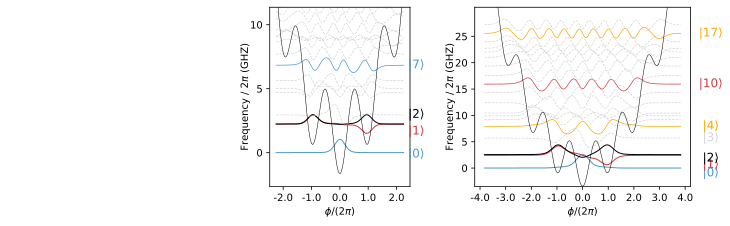

In [10]:
fig = plt.figure(figsize=(10,3))

wavefunc_width = 0.3
wspace = 0.09
right = 0.95
gs0 = fig.add_gridspec(nrows=1, ncols=1, wspace=0.0,left=0.0, right=0.33,bottom=0.0,top = 0.98)
gs1 = fig.add_gridspec(nrows=1, ncols=1, wspace=0.0,left=right-wavefunc_width*1.65-wspace, right=right-wavefunc_width-wspace,bottom=0.15,top = 0.98)
gs2 = fig.add_gridspec(nrows=1, ncols=1, wspace=0.0,left=right-wavefunc_width, right=right,bottom=0.15,top = 0.98)
ax0 = fig.add_subplot(gs0[0])
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs2[0])

ax0.axis('off')

wave_func_scaling = 0.5
def plot_ef_wavefunction(fig,ax):
    n_evals = 20
    qbt = scqubits.Fluxonium(EJ = 3,EC = 3/6,EL = 3/25, cutoff = 110,flux = 0,truncated_dim=n_evals)

    omega_0 = qbt.eigenvals()[0]
    color_used = ['#4999c3', '#d5373d', 'black']+['lightgrey']*4+['#4999c3']+['lightgrey']*10
    dashed = [0]*3+[1]*4+[0]+[1]*10
    lw = [1.0]*3+[0.7]*20
    fill = None
    fig, ax = plot_wavefunction( qbt, which=list(range(18)),colors = color_used,
                                                                    fill = fill,
                                                                    fig_ax =(fig, ax ),
                            scaling=wave_func_scaling,
                            phi_grid=Grid1d(min_val=  -14.137166941154069*1, max_val= 14.137166941154069*1, pt_count= 151) ,
                             dashed=dashed,lw=lw )
    ax.set_xticks(np.array([-2,-1,0,1,2])*2* np.pi)
    current_ticks = ax.get_xticks()
    modified_ticks = current_ticks /(2* np.pi)
    ax.set_xticklabels([f'{val:.1f}' for val in modified_ticks])
    ax.set_xlabel(r"$\phi/(2\pi)$")

    ax.set_yticks(np.array([0,5,10])+omega_0)
    # ax.set_yticks(np.array([0,30/(2*np.pi),60/(2*np.pi),90/(2*np.pi)])+omega_0  )
    current_ticks = ax.get_yticks()
    modified_ticks = current_ticks - omega_0
    # ax.set_yticklabels([f'{val*2*np.pi:.0f}' for val in modified_ticks])
    ax.set_yticklabels([f'{val:.0f}' for val in modified_ticks])
    ax.set_ylabel(rf'''Frequency / $2\pi$ (GHZ)''',labelpad = 0)
    # ax.set_ylabel(rf'''Frequency (GHz)''',labelpad = 0)
    ax.set_ylim(-4,10)

    evals = qbt.eigenvals(evals_count=10)
    evals[0] = -1.5
    evals[1] = 0.3
    evals[2] = 1.6
    for ql in [0,1,2,7]:
        ax.text(2.7*2*np.pi,evals[ql],rf"$|{ql}\rangle$",ha='center',va='center', fontsize=12,color=color_used[ql])

    # ax.text(0,-3.5,"m=0",ha='center', fontsize=12)
    # ax.text(-1*2* np.pi,     -0.7,"m=-1",ha='center', fontsize=12,color='grey')
    # ax.text(1*2* np.pi,     -0.7,"m=1",ha='center', fontsize=12,color='grey')
    # ax.text(-2*2* np.pi,    7.5,"m=-2",ha='center', fontsize=12,color='grey')
    # ax.text(2*2* np.pi,     7.5,"m=2",ha='center', fontsize=12,color='grey')
plot_ef_wavefunction(fig,ax1 )

def plot_ef_wavefunction(fig,ax):
    n_evals = 20
    qbt = scqubits.Fluxonium(EJ = 4,EC =4/2.0,EL = 4/30, cutoff = 110,flux = 0,truncated_dim=n_evals)
    omega_0 = qbt.eigenvals()[0]

    color_used = ['#4999c3', '#d5373d', 'black']+['lightgrey']*1 +['orange']+ ['lightgrey']*5+['#d5373d']+['lightgrey']*6+['orange']+['lightgrey']
    dashed = [0]*3 + [1] + [0]+[1]*5+[0]+[1]*6+[0]+[1]*2
    fill = None
    lw = [1.0]*3+[0.7]*17
    fig, ax = plot_wavefunction( qbt, which=list(range(n_evals)),colors = color_used,
                                                                    fill = fill,
                                                                    fig_ax =(fig, ax ),
                            scaling=wave_func_scaling,
                            phi_grid=Grid1d(min_val=  -14.137166941154069*1.7, max_val= 14.137166941154069*1.7, pt_count= 151) ,
                            dashed =  dashed,lw=lw)

    ax.set_xticks(np.array([-4,-3,-2,-1,0,1,2,3,4])*2* np.pi)
    current_ticks = ax.get_xticks()
    modified_ticks = current_ticks /(2* np.pi)
    ax.set_xticklabels([f'{val:.1f}' for val in modified_ticks])
    ax.set_xlabel(r"$\phi/(2\pi)$")

    ax.set_yticks(np.array([0,5,10,15,20,25])+omega_0)
    # ax.set_yticks(np.array([0,30/(2*np.pi),60/(2*np.pi),90/(2*np.pi)])+omega_0  )
    current_ticks = ax.get_yticks()
    modified_ticks = current_ticks - omega_0
    # ax.set_yticklabels([f'{val*2*np.pi:.0f}' for val in modified_ticks])
    ax.set_yticklabels([f'{val:.0f}' for val in modified_ticks])
    ax.set_ylabel(rf'''Frequency / $2\pi$ (GHZ)''',labelpad = 0)
    # ax.set_ylabel(rf'''Frequency (GHz)''',labelpad = 0)
    ax.set_ylim(-4,30)

    evals = qbt.eigenvals(evals_count=20)
    evals[0] = -1.5
    evals[1] = 0.1
    evals[2] = 1.3
    for ql in [0,1,2,3,4,10,17]:
        ax.text(5*2*np.pi,evals[ql],rf"$|{ql}\rangle$",ha='center',va='center', fontsize=12,color=color_used[ql])
    # ax.text(-1*2* np.pi,     -0.7,"m=-1",ha='center', fontsize=12,color='grey')
    # ax.text(1*2* np.pi,     -0.7,"m=1",ha='center', fontsize=12,color='grey')
    # ax.text(-2*2* np.pi,    7.5,"m=-2",ha='center', fontsize=12,color='grey')
    # ax.text(2*2* np.pi,     7.5,"m=2",ha='center', fontsize=12,color='grey')
plot_ef_wavefunction(fig,ax2 )


fig.savefig('wavefuncs_simple.pdf')

In [67]:
qbt = scqubits.Fluxonium(EJ = 3,EC = 3/4,EL = 3/20.5, cutoff = 110,flux = 0,truncated_dim=10)


In [60]:
(qbt.eigenvals()[1] - qbt.eigenvals()[0])*2*np.pi,  (qbt.eigenvals()[2] - qbt.eigenvals()[1])*2*np.pi

(10.531939469995956, 0.23626817440084094)

In [72]:
8.46111172*2*np.pi

53.162732841509

In [68]:
(qbt.eigenvals(evals_count=10)[7] - qbt.eigenvals(evals_count=10)[0])*2*np.pi - ( 8.46111172)*2*np.pi

0.32809332777090106

In [69]:
qbt = scqubits.Fluxonium(EJ = 4,EC =4/2.7,EL = 4/45, cutoff = 110,flux = 0,truncated_dim=20)

In [41]:
(qbt.eigenvals()[1] - qbt.eigenvals()[0])*2*np.pi,  (qbt.eigenvals()[2] - qbt.eigenvals()[1])*2*np.pi

(10.531939469995956, 0.23626817440084094)

In [46]:
(qbt.eigenvals(evals_count=10)[8] - qbt.eigenvals(evals_count=10)[1])*2*np.pi

50.117803018160835

In [47]:
10.38695526*2*np.pi 

65.26316467596372

In [70]:
10.38695526*2*np.pi - (qbt.eigenvals(evals_count=15)[10] - qbt.eigenvals(evals_count=15)[1])*2*np.pi

0.745366912655669

In [58]:
(10.389507326769158-10.38695526)*2*np.pi, (10.387331537957516-10.38695526)*2*np.pi

(0.016035108426908414, 0.002364224134078975)

In [54]:
(8.46111172 - 8.460155465243822)*2*np.pi

0.006008325833934712

In [53]:
from scipy.optimize import curve_fit
import scipy
from scipy.special import erfc
from skimage.transform import radon
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
from CoupledQuantumSystems.drive import DriveTerm, square_pulse_with_rise_fall
from CoupledQuantumSystems.mcsolve_utils import pack_mcsolve_chunks, pack_pkl_files_to_zip, merge_results
import matplotlib.pyplot as plt
import qutip
max_ql = 30
max_ol = 100
EJ = 4
EC = EJ/2.7
EL = EJ/45
Er = 10.38695526

g = 0.2
w_d = 10.389507326769158
amp = 0.005
tot_time =500

tlist = np.linspace(0, tot_time, tot_time)[::5]
kappa = 1e-3

system  =  FluxoniumOscillatorSystem(
                EJ = EJ,
                EC = EC,
                EL = EL,
                Er = Er,
                g_strength = g,
                qubit_level = max_ql,
                osc_level = max_ol,
                products_to_keep=[[ql, ol] for ql in range(15) for ol in range(max_ol) ],
                computaional_states = '0,2',
                )

In [56]:
system.evals[system.product_to_dressed[(1,1)]]-system.evals[system.product_to_dressed[(1,0)]]

10.389507326770264

In [57]:
system.evals[system.product_to_dressed[(2,1)]]-system.evals[system.product_to_dressed[(2,0)]]

10.387331537957516

In [73]:
10.38695526 * 2 * np.pi

65.26316467596372

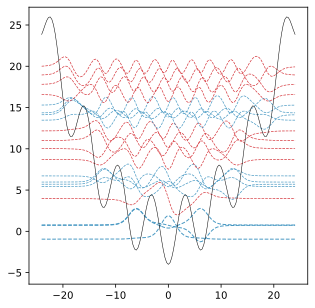

In [16]:
fig,ax = plt.subplots(figsize=(5,5))
qbt = scqubits.Fluxonium(EJ = 4,EC =4/2.7,EL = 4/45, cutoff = 110,flux = 0,truncated_dim=20)
omega_0 = qbt.eigenvals()[0]

color_used = ['#4999c3', '#4999c3', '#4999c3']+['#d5373d']*1 +['#4999c3']*4+ ['#d5373d']*4+['#4999c3']*4+['#d5373d']*10
dashed = [1]*3 + [1] *20
fill = None
lw = [1.0]*3+[0.7]*17
fig, ax = plot_wavefunction( qbt, which=list(range(20)),colors = color_used,
                                                                fill = fill,
                                                                fig_ax =(fig, ax ),
                        scaling=0.7,
                        phi_grid=Grid1d(min_val=  -14.137166941154069*1.7, max_val= 14.137166941154069*1.7, pt_count= 151) ,
                        dashed =  dashed,lw=lw)


fig.savefig('wavefuncs_ill.pdf')